In [1]:
from urllib import request
import nltk
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from textblob import TextBlob
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support, ConfusionMatrixDisplay, confusion_matrix, classification_report,f1_score
from mlxtend.evaluate import bias_variance_decomp
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from collections import defaultdict
%matplotlib inline
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def get_raw(url):
  response = request.urlopen(url) # open a connection to the specified url and get the server's response to the HTTP request
  raw = response.read().decode('utf-8-sig') # read the content of the HTTP response as a sequence of bytes and then decode these bytes into a Unicode string using the UTF-8 encoding. The result is the text content of the specified url.
  return raw

In [3]:
def get_raw_from_author_to_closing(title,author,url):
  raw= get_raw(url)
  opening_statement= '.*start.*ebook.*\n' # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object
  closing_statement= '.*end.*ebook.*\n'  # lowercase since we will do the search with the lowercase version of the raw text to guarantee a match object

  start_position= re.search(opening_statement,raw.lower()).end() # start position is the end position of the opening statement
  if re.search(title.lower(),raw[start_position:].lower()): # if opening statement is followed by title
    start_position += re.search(title.lower(),raw[start_position:].lower()).end() # update start position to be end of title
    if re.search((author).lower(),raw[start_position:].lower()): # if title is followed by author name
      start_position += re.search((author).lower(),raw[start_position:].lower()).end() #update start position to be end of author name

  end_position= re.search(closing_statement,raw.lower()).start() # end position is the start position of the closing statement
  return raw[start_position:end_position]

In [4]:
def get_tokens(raw):
  words= nltk.word_tokenize(raw)
  return words

In [5]:
def extract_partitions(title,author,url,num_partitions,num_words_per_partition):
  raw= get_raw_from_author_to_closing(title,author,url) # get raw text from url
  words= get_tokens(raw) # get list of words/tokens from raw text
  partitions= []
  for i in range(num_partitions):
    start_index = random.randint(0, len(words) - num_words_per_partition) # generates a random starting index within the range of valid indices for the words list i.e. in such a way that the selected partition will not go beyond the end of the list
    partition = ' '.join(words[start_index:start_index + num_words_per_partition]) # Extracts a consecutive sequence of num_words_per_partition words starting from a the random position start_index and extending up to start_index + num_words_per_partition and joins the selected words into a single string by using space ' ' as a separator to form a sentence-like structure
    partitions.append(partition) # saves the partition in the list of partitions
  return partitions

In [6]:
def extract_from_multiple_books(books_details,num_partitions,num_words_per_partition):
  dict={'Partition':[],'Label':[], 'Book Title':[], 'Book Author':[]} # will be used to save each partition with its label and the title and author it belongs to
  for i in range(len(books_details)):
    partitions= extract_partitions(books_details[i]['title'],books_details[i]['author'],books_details[i]['url'],num_partitions,num_words_per_partition)
    for partition in partitions:
      dict['Partition'].append(partition)
      dict['Label'].append(books_details[i]['label'])
      dict['Book Title'].append(books_details[i]['title'])
      dict['Book Author'].append(books_details[i]['author'])
  return dict

In [7]:
def extract_and_save(books_details,num_partitions,num_words_per_partition):
  dict= extract_from_multiple_books(books_details,num_partitions,num_words_per_partition)

  # Assign series for partitions, labels, titles, and authors
  partitions= pd.Series(dict['Partition'])
  labels= pd.Series(dict['Label'])
  titles= pd.Series(dict['Book Title'])
  authors= pd.Series(dict['Book Author'])

  # Construct a data frame from the above series
  data= pd.DataFrame({'Book Title':titles, 'Book Author':authors, 'Label':labels, 'Partition':partitions })

  # Save the data to a csv file
  data.to_csv('sample_partitions.csv', index=False, encoding= 'utf-8-sig')
  return data

In [8]:
# Book 1 Details https://www.gutenberg.org/cache/epub/3695/pg3695.txt
url1 = 'https://www.gutenberg.org/cache/epub/4081/pg4081.txt'
title1= 'The Alchemist'
author1= 'Ben Jonson'
label1= 'a'
dict1= {'title':title1, 'author':author1, 'url':url1, 'label':label1}

# Book 2 Details
url2= 'https://www.gutenberg.org/cache/epub/1656/pg1656.txt'
title2= 'Apology'
author2= 'Plato'
label2= 'b'
dict2= {'title':title2, 'author':author2, 'url':url2, 'label':label2}

# Book 3 Details
url3= 'https://www.gutenberg.org/cache/epub/996/pg996.txt'
title3= 'Don Quixote'
author3= 'Miguel de Cervantes Saavedra'
label3= 'c'
dict3= {'title':title3, 'author':author3, 'url':url3, 'label':label3}

# Book 4 Details
url4= 'https://www.gutenberg.org/cache/epub/766/pg766.txt'
title4= 'David Copperfield'
author4= 'Charles Dickens'
label4= 'd'
dict4= {'title':title4, 'author':author4, 'url':url4, 'label':label4}

# Book 5 Details
url5= 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt'
title5= 'The Odyssey'
author5= 'Homer'
label5= 'e'
dict5= {'title':title5, 'author':author5, 'url':url5, 'label':label5}

# Book 6 Details
url6= 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt'
title6= 'Crime and Punishment'
author6= 'Fyodor Dostoyevsky'
label6= 'f'
dict6= {'title':title6, 'author':author6, 'url':url6, 'label':label6}

# All Books Details
books_details= [dict1, dict2, dict3, dict4,dict5, dict6]
books_details

[{'title': 'The Alchemist',
  'author': 'Ben Jonson',
  'url': 'https://www.gutenberg.org/cache/epub/4081/pg4081.txt',
  'label': 'a'},
 {'title': 'Apology',
  'author': 'Plato',
  'url': 'https://www.gutenberg.org/cache/epub/1656/pg1656.txt',
  'label': 'b'},
 {'title': 'Don Quixote',
  'author': 'Miguel de Cervantes Saavedra',
  'url': 'https://www.gutenberg.org/cache/epub/996/pg996.txt',
  'label': 'c'},
 {'title': 'David Copperfield',
  'author': 'Charles Dickens',
  'url': 'https://www.gutenberg.org/cache/epub/766/pg766.txt',
  'label': 'd'},
 {'title': 'The Odyssey',
  'author': 'Homer',
  'url': 'https://www.gutenberg.org/cache/epub/1727/pg1727.txt',
  'label': 'e'},
 {'title': 'Crime and Punishment',
  'author': 'Fyodor Dostoyevsky',
  'url': 'https://www.gutenberg.org/cache/epub/2554/pg2554.txt',
  'label': 'f'}]

In [9]:
data= extract_and_save(books_details,num_partitions=200,num_words_per_partition=150)

In [10]:
data

,Book Title,Book Author,Label,Partition
0,The Alchemist,Ben Jonson,a,"faults , Now I do think o n't better . SUB . W..."
1,The Alchemist,Ben Jonson,a,", his issue , And his posterity noble . DOL . ..."
2,The Alchemist,Ben Jonson,a,"spurious , counterfeit . ADVANCE , lift . ADVE..."
3,The Alchemist,Ben Jonson,a,TO FACE . ] You will accuse him ! you will `` ...
4,The Alchemist,Ben Jonson,a,"? SUB . Ods will , she must go to him , man , ..."
...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,", ” she said , laying it on the table . “ Can ..."
1196,Crime and Punishment,Fyodor Dostoyevsky,f,by this time he stinketh : for he hath been de...
1197,Crime and Punishment,Fyodor Dostoyevsky,f,but he felt clearly with all the intensity of ...
1198,Crime and Punishment,Fyodor Dostoyevsky,f,you owe me now twenty copecks on the same reck...


In [11]:
def clean_text_stem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_stemmed=' '.join([nltk.PorterStemmer().stem(word) for word in text_nostop])
  return text_stemmed

def clean_text_lem(text):
  text= text.lower()
  text= ''.join([char for char in text if char not in (string.punctuation + "‘’“”") ]) # remove punctuation to prevent tokenize function from considering them as words
  tokens= get_tokens(text)
  text_nostop= [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]
  text_lemmatized= ' '.join([nltk.WordNetLemmatizer().lemmatize(word) for word in text_nostop])
  return text_lemmatized

data['Partition_stemmed']= data['Partition'].apply(lambda x: clean_text_stem(x))
data['Partition_lemmatized']= data['Partition'].apply(lambda x: clean_text_lem(x))
data

,Book Title,Book Author,Label,Partition,Partition_stemmed,Partition_lemmatized
0,The Alchemist,Ben Jonson,a,"faults , Now I do think o n't better . SUB . W...",fault think nt better sub heart sir discharg l...,fault think nt better sub heart sir discharged...
1,The Alchemist,Ben Jonson,a,", his issue , And his posterity noble . DOL . ...",issu poster nobl dol sir although may said wan...,issue posterity noble dol sir although may sai...
2,The Alchemist,Ben Jonson,a,"spurious , counterfeit . ADVANCE , lift . ADVE...",spuriou counterfeit advanc lift advertis infor...,spurious counterfeit advance lift advertise in...
3,The Alchemist,Ben Jonson,a,TO FACE . ] You will accuse him ! you will `` ...,face accus bring within statut shall take word...,face accuse bring within statute shall take wo...
4,The Alchemist,Ben Jonson,a,"? SUB . Ods will , she must go to him , man , ...",sub od must go man kiss spanish fashion women ...,sub od must go man kiss spanish fashion woman ...
...,...,...,...,...,...,...
1195,Crime and Punishment,Fyodor Dostoyevsky,f,", ” she said , laying it on the table . “ Can ...",said lay tabl true write hint crime commit say...,said laying table true write hint crime commit...
1196,Crime and Punishment,Fyodor Dostoyevsky,f,by this time he stinketh : for he hath been de...,time stinketh hath dead four day laid emphasi ...,time stinketh hath dead four day laid emphasis...
1197,Crime and Punishment,Fyodor Dostoyevsky,f,but he felt clearly with all the intensity of ...,felt clearli intens sensat could never appeal ...,felt clearly intensity sensation could never a...
1198,Crime and Punishment,Fyodor Dostoyevsky,f,you owe me now twenty copecks on the same reck...,owe twenti copeck reckon advanc make thirtyf c...,owe twenty copeck reckoning advance make thirt...


Training and Testing

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data['Partition_lemmatized'], data['Book Author'], test_size=0.2, random_state=42)

In [13]:
X_train.to_csv('X_train.csv', index=False, header=True, encoding= 'utf-8-sig')
X_test.to_csv('X_test.csv', index=False, header=True, encoding= 'utf-8-sig')
y_train.to_csv('y_train.csv', index=False, header=True, encoding= 'utf-8-sig')
y_test.to_csv('y_test.csv', index=False, header=True, encoding= 'utf-8-sig')

In [14]:
X_train= pd.read_csv('X_train.csv', encoding= 'utf-8-sig')
X_test= pd.read_csv('X_test.csv', encoding= 'utf-8-sig')
y_train= pd.read_csv('y_train.csv', encoding= 'utf-8-sig')
y_test= pd.read_csv('y_test.csv', encoding= 'utf-8-sig')

Vectorization function (tf-idf and bow)

In [15]:
def vectorize_text(data, column, method='tfidf'):
    if method == 'tfidf':
        vectorizer = TfidfVectorizer()
    elif method == 'bow':
        vectorizer = CountVectorizer()
    else:
        raise ValueError("Invalid method. Choose 'tfidf' or 'bow'.")

    vectorizer.fit(data[column])
    X_vectorized = vectorizer.transform(data[column])
    return X_vectorized, vectorizer

#K-means clustering

In [16]:
def perform_kmeans(X_train, X_test, n_clusters=6):
    kmeans = KMeans(n_clusters=6, random_state=42)
    kmeans.fit(X_train)
    train_cluster_labels = kmeans.predict(X_train)
    test_cluster_labels = kmeans.predict(X_test)
    return train_cluster_labels, test_cluster_labels

Print cluster

In [17]:
def print_cluster_data(X_test, test_cluster_labels, y_test):
    # Add cluster labels to the test data
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['Cluster'] = test_cluster_labels

    # Initialize a dictionary to store samples for each cluster
    cluster_samples = {}

    # Iterate over unique cluster labels
    for cluster_label in np.unique(test_cluster_labels):
        # Get indices of samples belonging to the current cluster
        indices = np.where(test_cluster_labels == cluster_label)[0]
        # Get the samples
        samples = X_test_with_clusters.iloc[indices]
        # Add the samples to the dictionary
        cluster_samples[cluster_label] = samples

    # Display the samples for each cluster
    for cluster_label, samples in cluster_samples.items():
        author = y_test.iloc[samples.index[0]]  # Get author name from y_test
        print(f"Cluster: {cluster_label}, Author: {author.values[0]}")  # Print cluster label and author name
        for i, sample in samples.iterrows():
            partition = sample['Partition_lemmatized']
            print(f"  {partition}\n")
        print()

Get Cluster Data (Dictionary form)

In [18]:
def get_cluster_data(X_test, test_cluster_labels, y_test):
    # Add cluster labels to the test data
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['Cluster'] = test_cluster_labels

    # Initialize a dictionary to store samples for each author
    author_samples = {}

    # Iterate over unique cluster labels
    for cluster_label in np.unique(test_cluster_labels):
        # Get indices of samples belonging to the current cluster
        indices = np.where(test_cluster_labels == cluster_label)[0]
        # Get the samples
        samples = X_test_with_clusters.iloc[indices]
        # Get the author for the current cluster
        author = y_test.iloc[samples.index[0]].values[0]
        # Add the samples to the dictionary
        if author in author_samples:
            author_samples[author].extend(samples['Partition_lemmatized'].tolist())
        else:
            author_samples[author] = samples['Partition_lemmatized'].tolist()

    return author_samples

Cluster Visualization/Distribution

In [19]:
def visualize_clusters(X_train, cluster_labels, y_train):
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train.toarray())  # Convert sparse matrix to dense array

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
    df['Cluster'] = cluster_labels
    df['Author'] = y_train.values

    # Create a mapping of cluster labels to majority author names
    cluster_to_majority_author = {}
    for cluster_label in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster_label]
        majority_author = cluster_data['Author'].mode()[0]
        cluster_to_majority_author[cluster_label] = majority_author

    # Map cluster labels to majority author names
    df['Majority_Author'] = df['Cluster'].map(cluster_to_majority_author)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Majority_Author', data=df, palette='tab10')
    plt.title('PCA Visualization of Clusters (Author Names)')
    plt.show()

Kappa score against authors

In [20]:
def calculate_kappa_score(y_test, test_cluster_labels):
    cluster_to_majority_author = {}
    for cluster_label in np.unique(test_cluster_labels):
        indices = np.where(test_cluster_labels == cluster_label)[0]
        author_labels = y_test.iloc[indices]
        majority_author_label = author_labels.value_counts().idxmax()
        cluster_to_majority_author[cluster_label] = majority_author_label

    test_cluster_author = [cluster_to_majority_author[label] for label in test_cluster_labels]

    kappa = cohen_kappa_score(y_test, test_cluster_author)
    return kappa

#Results of tf-idf - - k-means

In [21]:
X_train_tfidf, tfidf_vectorizer = vectorize_text(X_train, 'Partition_lemmatized', method='tfidf')
X_test_tfidf = tfidf_vectorizer.transform(X_test['Partition_lemmatized'])

Clustering

In [22]:
train_cluster_labels_tfidf, test_cluster_labels_tfidf = perform_kmeans(X_train_tfidf, X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster data (tf-idf - - k-means)

In [23]:
get_cluster_data(X_test, test_cluster_labels_tfidf, y_test)

{'Plato': ['accusing anaxagoras bad opinion judge fancy illiterate degree know doctrine found book anaxagoras clazomenian full forsooth youth said taught socrates unfrequently exhibition theatre probably allusion aristophanes caricatured euripides borrowed notion anaxagoras well dramatic poet price admission one drachma might pay money laugh socrates pretend father extraordinary view meletus really think believe',
  'said plato view situation plato like xenophon chronicler fact appear writing aimed literal accuracy therefore supplemented memorabilia symposium xenophon belongs entirely different class writer apology plato report socrates said elaborate composition quite much fact one dialogue may perhaps even indulge fancy actual defence socrates much greater platonic defence master greater disciple case word used must remembered',
  'easily find another like therefore would advise spare dare say may feel temper like person suddenly awakened sleep think might easily strike dead anytus a

Cluster Distribution (tf-idf - - k-means)

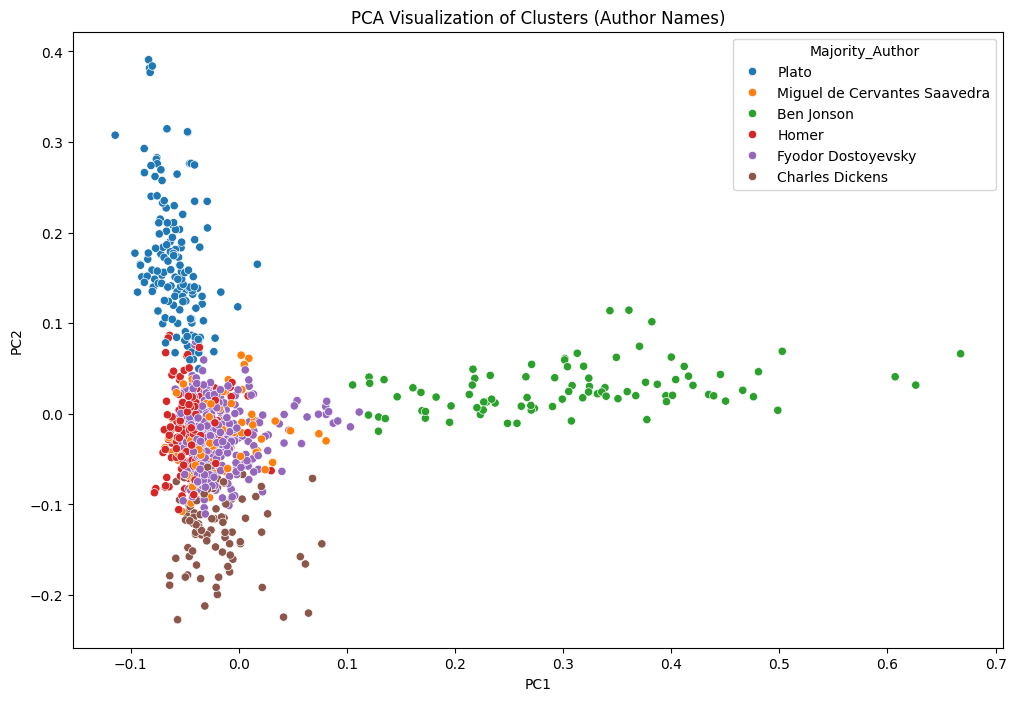

In [24]:
visualize_clusters(X_train_tfidf, train_cluster_labels_tfidf, y_train)

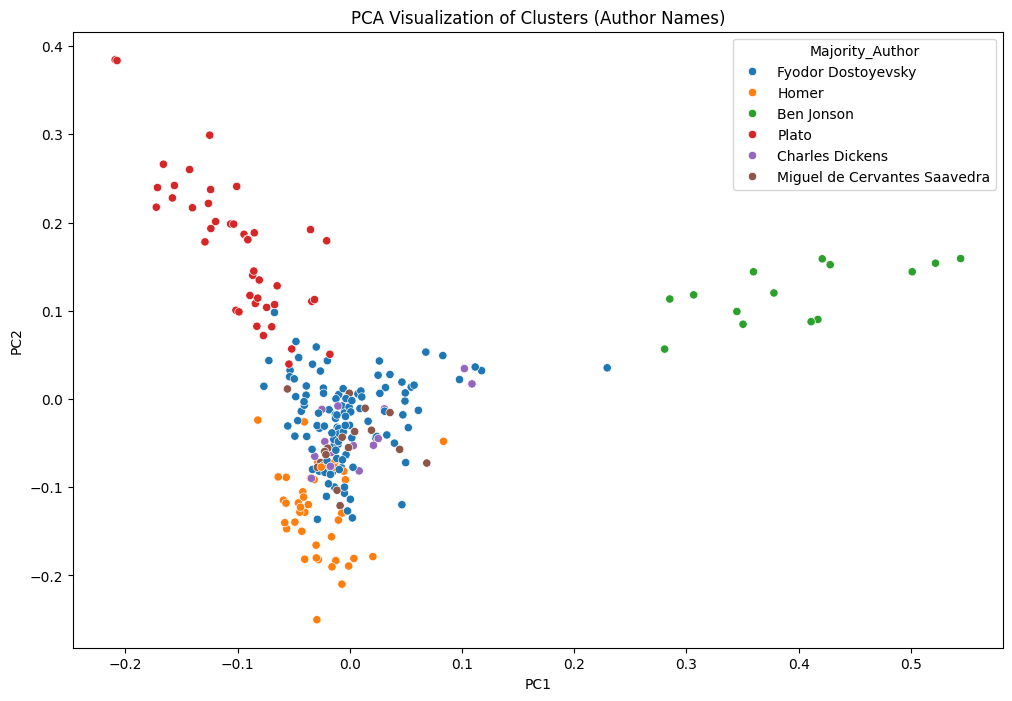

In [25]:
visualize_clusters(X_test_tfidf, test_cluster_labels_tfidf, y_test)

Kappa score against authors for tf-idf - - k-means

In [26]:
kappa_tfidf_test = calculate_kappa_score(y_test, test_cluster_labels_tfidf)
print(f"Cohen's Kappa (TF-IDF): {kappa_tfidf_test}")

Cohen's Kappa (TF-IDF): 0.6210500072715186


In [27]:
kappa_tfidf_train = calculate_kappa_score(y_train, train_cluster_labels_tfidf)
print(f"Cohen's Kappa (TF-IDF): {kappa_tfidf_train}")

Cohen's Kappa (TF-IDF): 0.7234741943135993


#Results of bow - - k-means

Vectorization using bow

In [28]:
X_train_bow, bow_vectorizer = vectorize_text(X_train, 'Partition_lemmatized', method='bow')
X_test_bow = bow_vectorizer.transform(X_test['Partition_lemmatized'])

Clustering

In [29]:
train_cluster_labels_bow, test_cluster_labels_bow = perform_kmeans(X_train_bow, X_test_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster data (BOW -- k-means)

In [30]:
get_cluster_data(X_test, test_cluster_labels_bow, y_test)

{'Homer': ['groaning hooting house ulysses took dead away buried every man put body came elsewhere board fishing vessel fisherman take place met angrily place assembly got together eupeithes rose speak overwhelmed grief death son antinous first man killed ulysses said weeping bitterly friend man done achaean great wrong took many best men away fleet lost ship men moreover return killing',
  'man ulysses stuck keel ship drifted land phaeacians near kin immortal treated though god giving many present wishing escort home safe sound fact ulysses would long ago thought better go land land gathering wealth man living wily one compare pheidon king thesprotians told swore me—making drinkofferings house so—that ship water side crew found would take ulysses country sent',
  'laid cloak bench seat sacrificed sheep goat pig heifer inward meat cooked served round mixed wine mixingbowls swineherd gave every man cup philoetius handed round bread bread basket melanthius poured wine laid hand upon good

Cluster distribution/visualization (bow -- k-means)

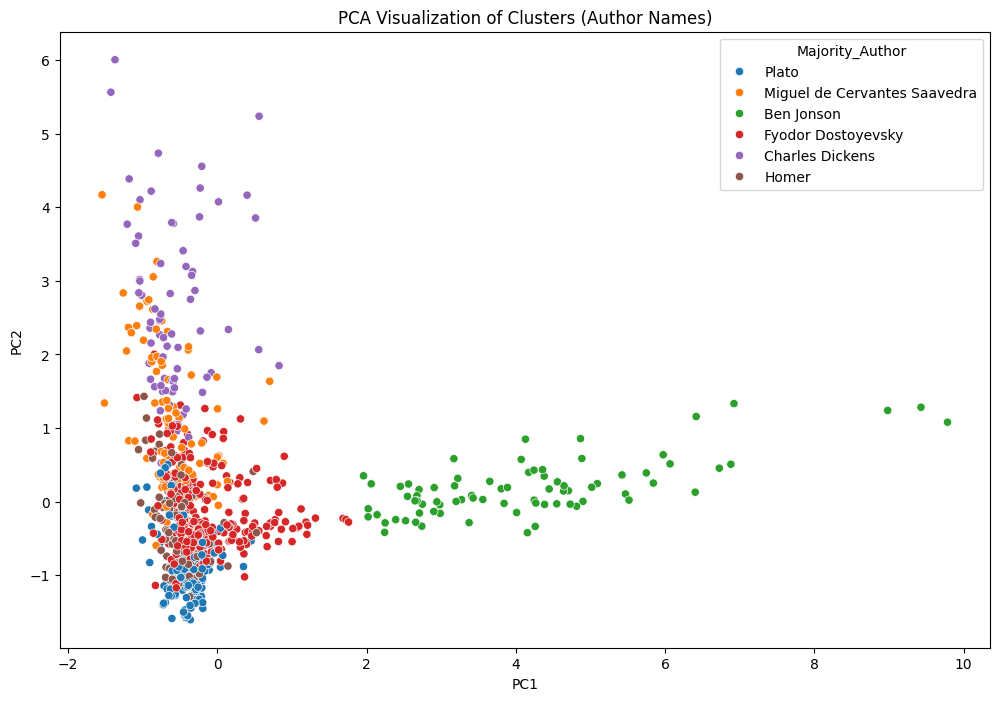

In [31]:
visualize_clusters(X_train_bow, train_cluster_labels_bow, y_train)

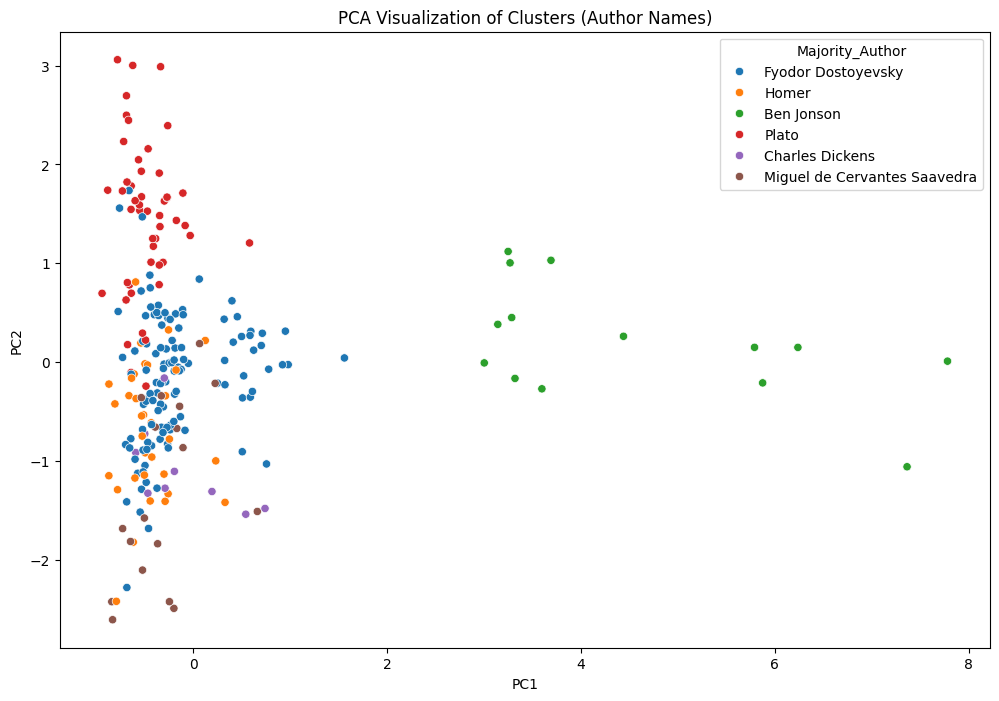

In [32]:
visualize_clusters(X_test_bow, test_cluster_labels_bow, y_test)

Kappa score against authors for bow - - k-means

In [33]:
kappa_bow_test = calculate_kappa_score(y_test, test_cluster_labels_bow)
print(f"Cohen's Kappa (BOW): {kappa_bow_test}")

Cohen's Kappa (BOW): 0.566265060240964


In [34]:
kappa_bow_train = calculate_kappa_score(y_train, train_cluster_labels_bow)
print(f"Cohen's Kappa (BOW): {kappa_bow_train}")

Cohen's Kappa (BOW): 0.6283270284151494


Coherence

In [35]:
dict_1_train = get_cluster_data(X_train, train_cluster_labels_tfidf, y_train)
dict_2_train = get_cluster_data(X_train, train_cluster_labels_bow, y_train)

In [36]:
dict_1_test = get_cluster_data(X_test, test_cluster_labels_tfidf, y_test)
dict_2_test = get_cluster_data(X_test, test_cluster_labels_bow, y_test)

In [37]:
dict_1_train

{'Plato': ['state acknowledges new divinity spiritual agency stead lesson corrupt youth say yes say emphatically god meletus speaking tell court somewhat plainer term mean yet understand whether affirm teach men acknowledge god therefore believe god entire atheist—this lay charge —but say god city recognizes—the charge different god mean atheist simply teacher',
  'answer socrates never professed teach anything therefore justly chargeable crime yet defence taken ironical form doubtless sound teaching nothing evil life sophistry rather form substance though might desire serious charge socrates given serious answer truly characteristic socrates another point answer may also regarded sophistical say corrupted youth must corrupted involuntarily socrates argues evil involuntary criminal ought admonished punished word socratic doctrine involuntariness',
  'enquire speculate way caught shall die —if condition let go reply men athens honour love shall obey god rather life strength shall never 

In [38]:
dict_2_test

{'Homer': ['groaning hooting house ulysses took dead away buried every man put body came elsewhere board fishing vessel fisherman take place met angrily place assembly got together eupeithes rose speak overwhelmed grief death son antinous first man killed ulysses said weeping bitterly friend man done achaean great wrong took many best men away fleet lost ship men moreover return killing',
  'man ulysses stuck keel ship drifted land phaeacians near kin immortal treated though god giving many present wishing escort home safe sound fact ulysses would long ago thought better go land land gathering wealth man living wily one compare pheidon king thesprotians told swore me—making drinkofferings house so—that ship water side crew found would take ulysses country sent',
  'laid cloak bench seat sacrificed sheep goat pig heifer inward meat cooked served round mixed wine mixingbowls swineherd gave every man cup philoetius handed round bread bread basket melanthius poured wine laid hand upon good

Coherence

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_coherence(dict_1, dict_2):
    coherence_scores = {}

    for author in dict_1.keys():
        if author in dict_2:
            # Concatenate all samples for the author from both dictionaries
            all_samples = dict_1[author] + dict_2[author]

            # Initialize a TF-IDF vectorizer
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform(all_samples)

            # Calculate cosine similarity between the samples
            similarity_matrix = cosine_similarity(tfidf_matrix)

            # Get the similarity score between the samples from dict_1 and dict_2
            similarity_score = similarity_matrix[:len(dict_1[author]), len(dict_1[author]):].mean()

            coherence_scores[author] = similarity_score

    return coherence_scores

In [40]:
coherence_scores_train = calculate_coherence(dict_1_train, dict_2_train)
for author, score in coherence_scores_train.items():
    print(f"Coherence score for {author}: {score}")

Coherence score for Plato: 0.056766326669144995
Coherence score for Homer: 0.02855562344573476
Coherence score for Charles Dickens: 0.051736919899424715
Coherence score for Ben Jonson: 0.08103038315928773
Coherence score for Miguel de Cervantes Saavedra: 0.028555574965540315


In [41]:
coherence_scores_test = calculate_coherence(dict_1_test, dict_2_test)
for author, score in coherence_scores_test.items():
    print(f"Coherence score for {author}: {score}")

Coherence score for Plato: 0.07058161356761997
Coherence score for Homer: 0.07550526019639545
Coherence score for Charles Dickens: 0.11333043605856688
Coherence score for Ben Jonson: 0.1524596938993741
Coherence score for Miguel de Cervantes Saavedra: 0.10247330227863277
Coherence score for Fyodor Dostoyevsky: 0.02993053194076935


Silhouette

In [42]:
from sklearn.metrics import silhouette_score

In [43]:
#X_test_tfidf
#test_cluster_labels_tfidf
silhouette_avg_train = silhouette_score(X_train_tfidf, train_cluster_labels_tfidf)
print("Silhouette Score:", silhouette_avg_train)

Silhouette Score: 0.01275939568122206


In [44]:
silhouette_avg_test = silhouette_score(X_test_bow, test_cluster_labels_bow)
print("Silhouette Score:", silhouette_avg_test)

Silhouette Score: 0.015649210784621927


# Hierarchical Clustering


In [45]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from yellowbrick.text import TSNEVisualizer
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# Function to calculate kappa score against authors

In [46]:
def calculate_kappa_score(y_test, test_cluster_labels):
    cluster_to_majority_author = {}
    for cluster_label in np.unique(test_cluster_labels):
        indices = np.where(test_cluster_labels == cluster_label)[0]
        author_labels = y_test.iloc[indices]
        majority_author_label = author_labels.value_counts().idxmax()
        cluster_to_majority_author[cluster_label] = majority_author_label

    test_cluster_author = [cluster_to_majority_author[label] for label in test_cluster_labels]

    kappa = cohen_kappa_score(y_test, test_cluster_author)
    return kappa

# Function to get cluster data & calculate coherence score against authors

In [47]:
def get_cluster_data(X_test, test_cluster_labels, y_test):
    # Add cluster labels to the test data
    X_test_with_clusters = X_test.copy()
    X_test_with_clusters['Cluster'] = test_cluster_labels

    # Initialize a dictionary to store samples for each author
    author_samples = {}

    # Iterate over unique cluster labels
    for cluster_label in np.unique(test_cluster_labels):
        # Get indices of samples belonging to the current cluster
        indices = np.where(test_cluster_labels == cluster_label)[0]
        # Get the samples
        samples = X_test_with_clusters.iloc[indices]
        # Get the author for the current cluster
        author = y_test.iloc[samples.index[0]].values[0]
        # Add the samples to the dictionary
        if author in author_samples:
            author_samples[author].extend(samples['Partition_lemmatized'].tolist())
        else:
            author_samples[author] = samples['Partition_lemmatized'].tolist()

    return author_samples

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_coherence(dict_1, dict_2):
    coherence_scores = {}

    for author in dict_1.keys():
        if author in dict_2:
            # Concatenate all samples for the author from both dictionaries
            all_samples = dict_1[author] + dict_2[author]

            # Initialize a TF-IDF vectorizer
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform(all_samples)

            # Calculate cosine similarity between the samples
            similarity_matrix = cosine_similarity(tfidf_matrix)

            # Get the similarity score between the samples from dict_1 and dict_2
            similarity_score = similarity_matrix[:len(dict_1[author]), len(dict_1[author]):].mean()

            coherence_scores[author] = similarity_score

    return coherence_scores

#Plotting the dendrogram

In [49]:
text_embedding = {
    'bow' : X_train_bow.toarray(),
    'tfidf' : X_train_tfidf.toarray()
}

# Hierarchical clustering for **bow**

In [50]:
X_train_bow, bow_vectorizer = vectorize_text(X_train, 'Partition_lemmatized', method='bow')
X_test_bow = bow_vectorizer.transform(X_test['Partition_lemmatized'])

Text(0.5, 0, 'data')

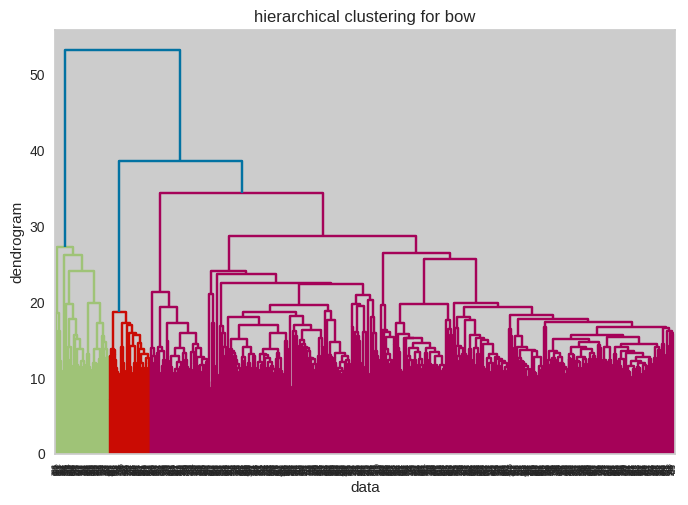

In [51]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

dendrogram = sch.dendrogram(sch.linkage(text_embedding['bow'], method='ward'))
hc_bow = AgglomerativeClustering(n_clusters=6, metric = 'euclidean', linkage = 'ward')
y_hc = hc_bow.fit_predict(text_embedding['bow'])
plt.title('hierarchical clustering for bow')
plt.ylabel('dendrogram')
plt.xlabel('data')

# Calculating Kappa score for AgglomerativeClustering with bow

In [52]:
kappa_bow_train = calculate_kappa_score(y_train, hc_bow.labels_)
print(f"Cohen's Kappa (Hierarchical-BOW): {kappa_bow_train}")

Cohen's Kappa (Hierarchical-BOW): 0.4294056308654849


# Hierarchical clustering for **tfidf**

In [53]:
X_train_tfidf, tfidf_vectorizer = vectorize_text(X_train, 'Partition_lemmatized', method='tfidf')
X_test_tfidf = tfidf_vectorizer.transform(X_test['Partition_lemmatized'])

Text(0.5, 0, 'data')

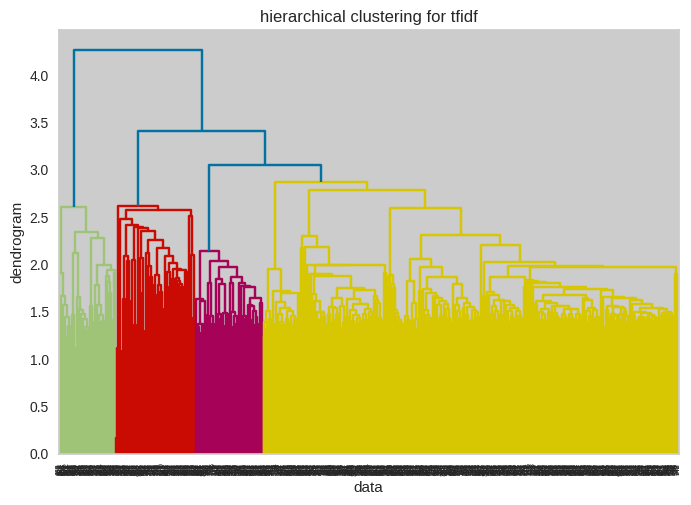

In [54]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

dendrogram = sch.dendrogram(sch.linkage(text_embedding['tfidf'], method='ward'))
hc_tfidf = AgglomerativeClustering(n_clusters=6, metric = 'euclidean', linkage = 'ward')
y_hc = hc_tfidf.fit_predict(text_embedding['tfidf'])
plt.title('hierarchical clustering for tfidf')
plt.ylabel('dendrogram')
plt.xlabel('data')

# Calculating Kappa score for AgglomerativeClustering with tfidf

In [55]:
kappa_tfidf_train = calculate_kappa_score(y_train, hc_tfidf.labels_)
print(f"Cohen's Kappa (Hierarchical-TFIDF): {kappa_tfidf_train}")

Cohen's Kappa (Hierarchical-TFIDF): 0.6206721176792771


# Visualizing silhouette score for AgglomerativeClustering with both bow and tfidf embeddings

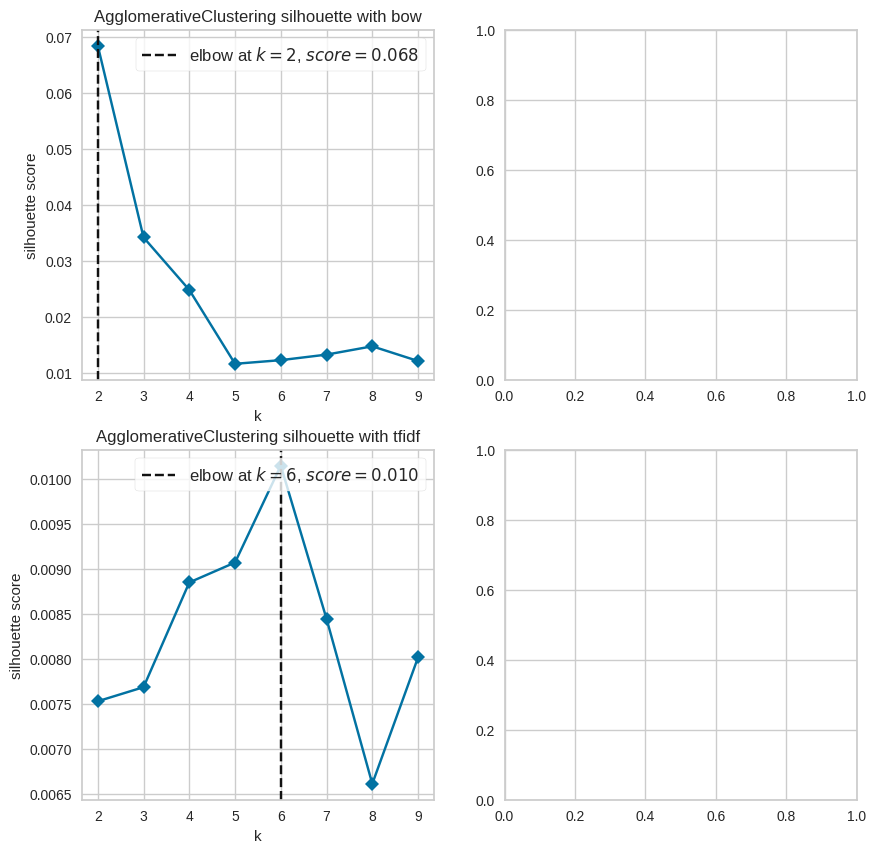

In [56]:
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
# from yellowbrick.features import FeatureImportances
# from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
# from sklearn.linear_model import LogisticRegression

x_size , y_size =2,2
fig, axes = plt.subplots(2, 2,figsize=(10,10))

model = AgglomerativeClustering()

visualgrid = []
for i in range(len(text_embedding.keys())):
    ax = axes[i % x_size][i // y_size]
    ax.set_title(text_embedding.keys())
    visualgrid.append(KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False, ax=axes[i%x_size][i//y_size], title = type(model).__name__ + ' silhouette with ' + list(text_embedding.keys())[i]))

for vis,key in zip(visualgrid,text_embedding.keys()):
    vis.fit(text_embedding[key])
    vis.ax.set_title(key)
    vis.finalize()

plt.show()

# Calculating coherence for AgglomerativeClustering with both bow and tfidf embeddings

In [62]:
dict_1_train_hc_tfidf = get_cluster_data(X_train, hc_tfidf.labels_, y_train)
dict_2_train_hc_bow = get_cluster_data(X_train, hc_bow.labels_, y_train)
coherence_scores_train = calculate_coherence(dict_1_train_hc_tfidf, dict_2_train_hc_bow)
for author, score in coherence_scores_train.items():
    print(f"Coherence score for {author}: {score}")


Coherence score for Plato: 0.045245810202000254
Coherence score for Ben Jonson: 0.07700702839812322
Coherence score for Miguel de Cervantes Saavedra: 0.027660113989200062
Coherence score for Charles Dickens: 0.049571446573508385
Coherence score for Homer: 0.028349068688505258
